In [90]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib.ticker import MultipleLocator
from matplotlib import ticker
from matplotlib import colors

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [110]:
import importlib
importlib.reload(general_functions)

<module 'general_functions' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/general_functions.py'>

In [31]:
def get_vars(dirname, depth_ind, time_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        
        vosaline0 = dsT.variables['vosaline'][time_ind, depth_ind, y, x]
        vosaline0_orig = dsT.variables['vosaline'][0, depth_ind, y, x]
        
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind,depth_ind,y,x]
        
        vomecrty0 = dsV.variables['vomecrty'][time_ind,depth_ind,y,x]
        
        vovecrtz0 = dsW.variables['vovecrtz'][time_ind,depth_ind,y,x]
        
        sozotaux = dsU.variables['sozotaux'][time_ind,0,0]
        deptht = dsT.variables['deptht'][depth_ind]
          
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, depth_ind, y, x]
        umask0 = dsM.variables['umask'][0,depth_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,depth_ind,y,x]
        
    tmask = np.tile(tmask0, (1,1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    vosaline_orig = np.ma.array(vosaline0_orig, mask=1 - tmask)
    
    umask = np.tile(umask0, (1,1, 1))  
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    vmask = np.tile(vmask0, (1,1, 1))  
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vovecrtz_cm = vovecrtz[:] * 100
    
    return vosaline, vosaline_orig, vozocrtx, vomecrty, vovecrtz_cm, sozotaux, deptht

In [100]:
def get_vars_cross(dirname, x_ind, time_ind, z_cut):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y = slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        vosaline0 = dsT.variables['vosaline'][time_ind, :z_cut, y, x_ind]
        deptht_c = dsT.variables['deptht'][:z_cut]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :z_cut, y, x_ind]
        
    tmask = np.tile(tmask0, (1 ,1, 1))  
    vosaline_c = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline_c, tmask0, deptht_c

In [158]:
def get_vars_cross2(dirname, y_ind, time_ind, z_cut):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    x = slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        vosaline0 = dsT.variables['vosaline'][time_ind, :z_cut, y_ind, x]
        deptht_c = dsT.variables['deptht'][:z_cut]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :z_cut, y_ind, x]
        
    tmask = np.tile(tmask0, (1 ,1, 1))  
    vosaline_c = np.ma.array(vosaline0, mask=1 - tmask)
    
    vosaline_c2, tmask02, deptht_c2 = vosaline_c, tmask0, deptht_c
    
    return vosaline_c2, tmask02, deptht_c2

In [227]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

depth_ind = 9
time_ind = (24*3)+8

vosaline, vosaline_orig, vozocrtx, vomecrty, vovecrtz, sozotaux, deptht = get_vars(dirname, depth_ind, time_ind)

salt_anom = vosaline - vosaline_orig

In [231]:
z_cut = depth_ind + 6
x_ind = 120
vosaline_c, tmask_c, deptht_c = get_vars_cross(dirname, x_ind, time_ind, z_cut)

y_ind = 60
vosaline_c2, tmask02, deptht_c2 = get_vars_cross2(dirname, y_ind, time_ind, z_cut)

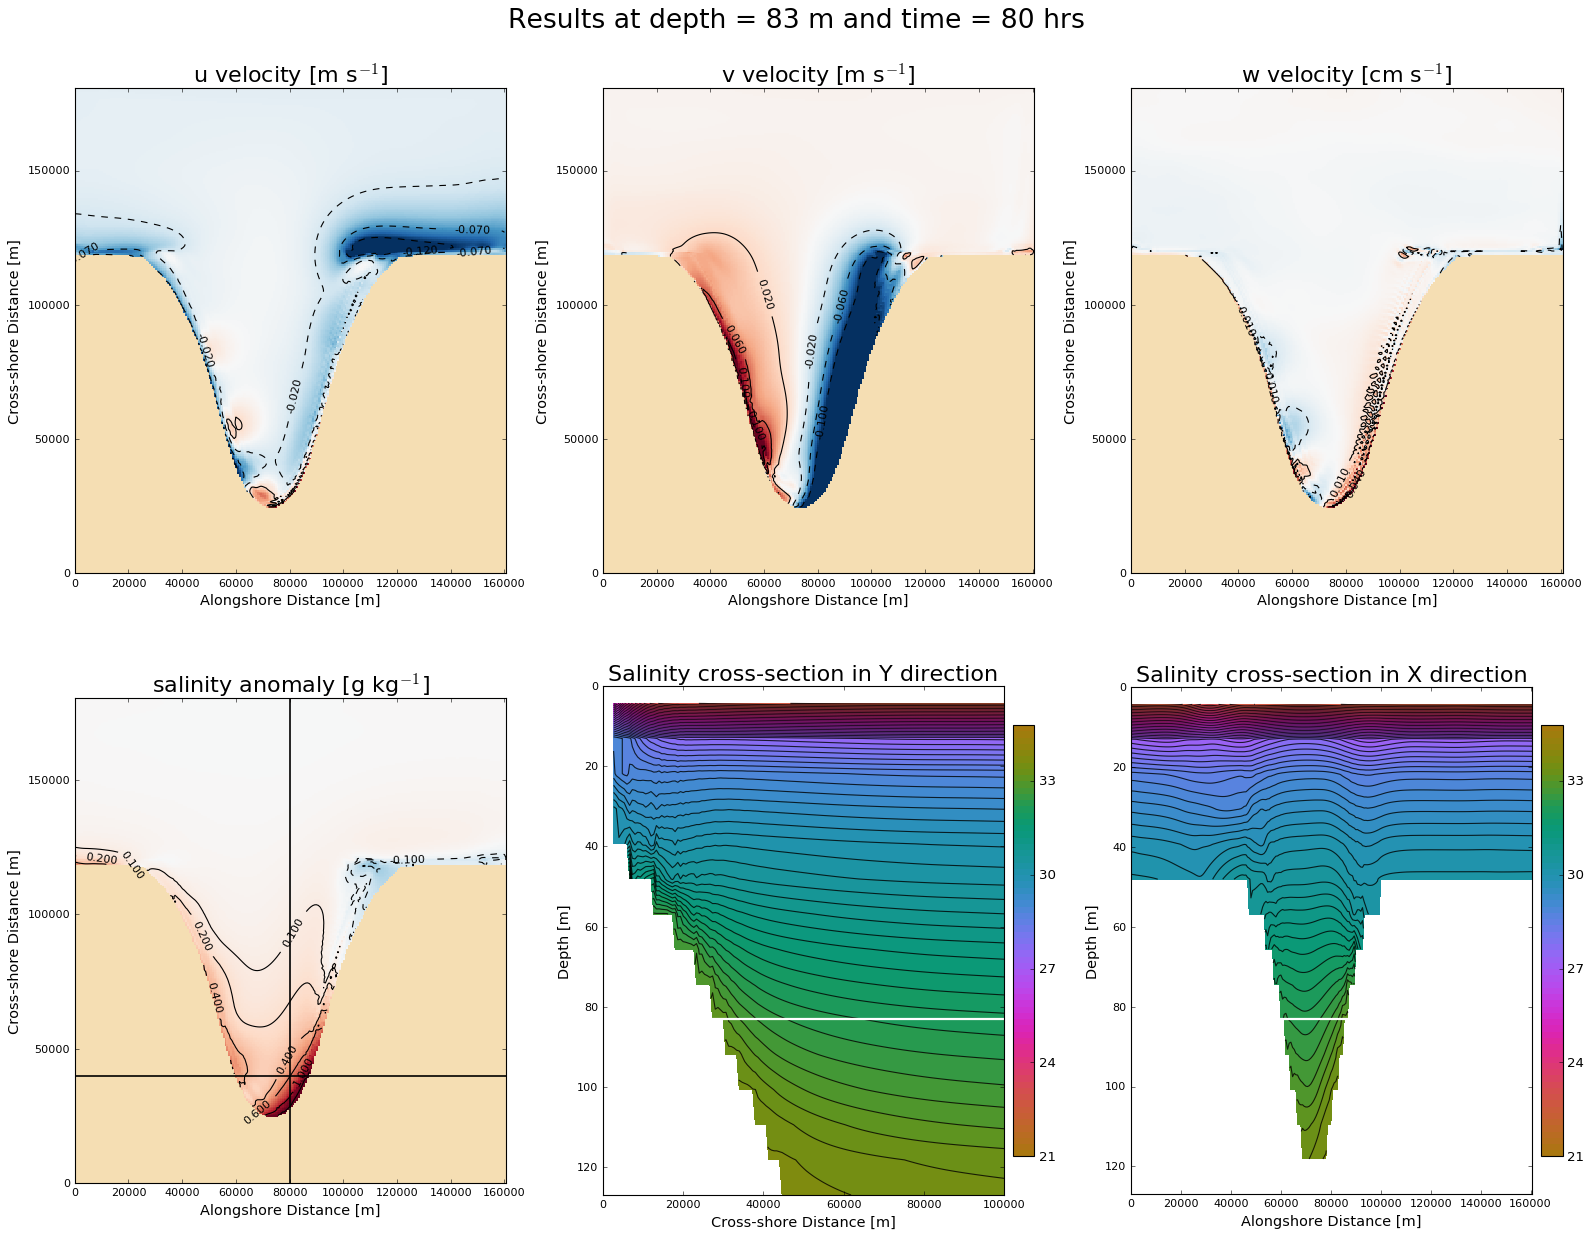

In [237]:
cmap = plt.get_cmap(cm.RdBu_r)
cmap.set_bad('wheat')
    
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(20, 16))

levelsU = [-0.12, -0.07, -0.02, 0.02, 0.07, 0.12]
levelsV = [-0.1, -0.06, -0.02, 0.02, 0.06, 0.1]
levelsW = [-0.06, -0.04, -0.01, 0.01, 0.04, 0.06]
levelsSA = [-1.2, -1.0, -0.6, -0.4, -0.2, -0.1, 0.1, 0.2, 0.4, 0.6, 1.0, 1.2]

axes = [ax1, ax2, ax3, ax4]
values = [vozocrtx, vomecrty, vovecrtz, salt_anom]
levels_all = [levelsU, levelsV, levelsW, levelsSA]
ttls = ['u velocity [m s$^{-1}$]', 'v velocity [m s$^{-1}$]', 'w velocity [cm s$^{-1}$]', 'salinity anomaly [g kg$^{-1}$]']

for ax, value, levels, ttl, n in zip(axes, values, levels_all, ttls, np.arange(4)):
    ax, xs, ys = general_functions.set_xy(ax, value, 'childm')
    #ax.pcolormesh(value)
    P = ax.pcolormesh(xs, ys, value, vmin = levels[0], vmax = levels[-1], cmap=cmap)
    cs = ax.contour(xs, ys, value, levels = levels, colors='k')
    ax.clabel(cs, inline=1, fontsize=10)
    ax.set_aspect(aspect='equal')
    #cbar = plt.colorbar(P, ax=ax, fraction=0.05, pad=0.02, orientation='vertical')
    #cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, fontsize=12)
    #tick_locator = ticker.MaxNLocator(nbins=5)
    #cbar.locator = tick_locator
    #cbar.update_ticks()
    ax.set_title(ttl, fontsize=20)
    ax.set_ylabel('Cross-shore Distance [m]', fontsize=13)
    ax.set_xlabel('Alongshore Distance [m]', fontsize=13)

levels = np.arange(21,35, 0.2)
cmap = plt.get_cmap(cmo.cm.phase)#plt.cm.get_cmap('gist_earth_r')

c5 = ax5.contourf(ys, deptht_c, vosaline_c, levels = levels, cmap = cmap)
ax5.contour(ys, deptht_c, vosaline_c, levels = levels, colors = 'k', alpha=0.8)
ax5.set_xlim([0, 100000])
ax5.set_ylim([deptht_c[-1], 0])
ax5.set_aspect(aspect=1000)
ax5.set_xlabel('Cross-shore Distance [m]', fontsize=13)

c6 = ax6.contourf(xs, deptht_c2, vosaline_c2, levels = levels, cmap = cmap)
ax6.contour(xs, deptht_c2, vosaline_c2, levels = levels, colors = 'k', alpha=0.8)
ax6.set_xlim([0, xs[-1]])
ax6.set_ylim([deptht_c2[-1], 0])
ax6.set_aspect(aspect=1600)
ax6.set_xlabel('Alongshore Distance [m]', fontsize=13)

for ax, c, n in zip([ax5, ax6], [c5, c6], np.arange(2)):
    ax.axhline(deptht, c='w', lw=2)
    cbar = plt.colorbar(c, ax=ax, fraction=0.05, pad=0.02, orientation='vertical')
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, fontsize=12)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    ax.set_ylabel('Depth [m]', fontsize=13)

ax4.axhline(ys[y_ind], c='k', lw=1.5)
ax4.axvline(xs[x_ind], c='k', lw=1.5)

ax5.set_title('Salinity cross-section in Y direction', fontsize=20)
ax6.set_title('Salinity cross-section in X direction', fontsize=20)
    
plt.tight_layout(h_pad=1.4, w_pad=0.9)
fig.suptitle('Results at depth = '+str(int(deptht))+' m and time = '+str(time_ind) + ' hrs', fontsize=24)
plt.subplots_adjust(top=0.95)
plt.savefig('story_sal_vel.png')